In [84]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import collections
import pandas as pd
import seaborn as sns

from river import compose
from river import preprocessing
from river import tree
from sklearn.model_selection import train_test_split

from source.config import *
from source.stability_analyzer import StabilityAnalyzer
from source.utils.incremental_model_utils import train_incremental_model
from source.folktables_dataset_from_pd import FolktablesDatasetFromPandas

In [86]:
sns.set(rc={'figure.figsize':(15, 5)})
dataset_name = 'folktables'
dataset_config = DATASETS_CONFIG[dataset_name]

In [87]:
# Creating a data frame
df = pd.read_csv("../../datasets/folktables-NY-2018.csv", delimiter=',')
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,26,21,5,17,2,0,5,1,4,1,2,2,2,2,2,1,0
1,21,20,5,17,2,0,1,3,4,1,1,2,2,2,1,1,1
2,18,16,5,17,2,0,2,3,4,1,1,2,2,2,2,8,0
3,85,16,2,16,1,0,1,1,4,4,1,1,2,1,2,1,0
4,19,19,5,17,2,0,1,1,4,2,1,2,2,2,2,1,1


In [88]:
df.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
      dtype='object')

In [89]:
df['ESR'].value_counts()

0    105496
1     91466
Name: ESR, dtype: int64

In [90]:
train_cv_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)
train_df, cv_df = train_test_split(train_cv_df, test_size=VALIDATION_SIZE, random_state=SEED)
print("train_df shape: ", train_df.shape)
print("cv_df shape: ", cv_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (126055, 17)
cv_df shape:  (31514, 17)
test_df shape:  (39393, 17)


In [91]:
train_df = train_df[:1000]
cv_df = cv_df[:1000]
test_df = test_df[:1000]

In [92]:
train_dataset = FolktablesDatasetFromPandas(pd_dataset=train_df)

In [93]:
counts = collections.Counter(y for _, y in train_dataset)
dataset_size = 0
for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')
    dataset_size += count

print('Dataset size: ', dataset_size)

0: 530 (53.00000%)
1: 470 (47.00000%)
Dataset size:  1000


In [94]:
TARGET_COLUMN = dataset_config['target_column']
numerical_features = dataset_config['numerical_features']
categorical_features = [feature for feature in df.columns if feature not in numerical_features + [TARGET_COLUMN]]

categorical_features

['MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

### Apply data transformations

In [95]:
def get_transform_pipeline(categorical_features, numerical_features):
    transform_pipeline = compose.Select(categorical_features[0])
    for feature in categorical_features[1:]:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.OneHotEncoder()

    for feature in numerical_features:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.MinMaxScaler()

    return transform_pipeline

In [96]:
transform_pipeline = get_transform_pipeline(categorical_features, numerical_features)

for idx, (x, y) in enumerate(train_dataset):
    print(f'Initial features: {x}\n')
    x = transform_pipeline.transform_one(x)
    print(f'Transformed features: {x}\n\n')
    if idx + 1 == 10:
        break

Initial features: {'': '7716', 'AGEP': 55, 'SCHL': 16, 'MAR': '5', 'RELP': '17', 'DIS': '1', 'ESP': '0', 'CIT': '1', 'MIG': '1', 'MIL': '4', 'ANC': '1', 'NATIVITY': '1', 'DEAR': '2', 'DEYE': '2', 'DREM': '1', 'SEX': '1', 'RAC1P': '2'}

Transformed features: {'SCHL': 0.0, 'AGEP': 0.0, 'RAC1P_2': 0.0, 'SEX_1': 0.0, 'DREM_1': 0.0, 'DEYE_2': 0.0, 'DEAR_2': 0.0, 'NATIVITY_1': 0.0, 'ANC_1': 0.0, 'MIL_4': 0.0, 'MIG_1': 0.0, 'CIT_1': 0.0, 'ESP_0': 0.0, 'DIS_1': 0.0, 'RELP_17': 0.0, 'MAR_5': 0.0}


Initial features: {'': '112348', 'AGEP': 13, 'SCHL': 10, 'MAR': '5', 'RELP': '2', 'DIS': '2', 'ESP': '7', 'CIT': '1', 'MIG': '1', 'MIL': '0', 'ANC': '4', 'NATIVITY': '1', 'DEAR': '2', 'DEYE': '2', 'DREM': '2', 'SEX': '2', 'RAC1P': '6'}

Transformed features: {'SCHL': 0.0, 'AGEP': 0.0, 'RAC1P_2': 0.0, 'RAC1P_6': 0.0, 'SEX_1': 0.0, 'SEX_2': 0.0, 'DREM_1': 0.0, 'DREM_2': 0.0, 'DEYE_2': 0.0, 'DEAR_2': 0.0, 'NATIVITY_1': 0.0, 'ANC_1': 0.0, 'ANC_4': 0.0, 'MIL_0': 0.0, 'MIL_4': 0.0, 'MIG_1': 0.0, 'CIT_1': 0

### Analyze stability of Adaptive Random Forest classifier

In [97]:
def get_base_model():
    return tree.HoeffdingTreeClassifier(grace_period=50, delta=0.01)

In [98]:
label_mapping = {
    False: 0,
    True: 1,
}
base_model = get_base_model()

# Conduct model training
base_model = train_incremental_model(base_model, train_dataset, dataset_size, train_fraction=0.6, label_mapping=label_mapping)

Metrics after incremental model training:
Accuracy: 53.92%
WeightedF1: 42.30%


In [99]:
stability_analyzer = StabilityAnalyzer(base_model, cv_df, test_df, test_y_true=test_df[TARGET_COLUMN], n_estimators=10)

2022-11-15 12:09:55 stability_analyzer.py INFO    : Start testing of classifier 1 / 10
2022-11-15 12:09:55 stability_analyzer.py INFO    : Classifier 1 / 10 was tested
2022-11-15 12:09:55 stability_analyzer.py INFO    : Start testing of classifier 2 / 10
2022-11-15 12:09:56 stability_analyzer.py INFO    : Classifier 2 / 10 was tested
2022-11-15 12:09:56 stability_analyzer.py INFO    : Start testing of classifier 3 / 10
2022-11-15 12:09:56 stability_analyzer.py INFO    : Classifier 3 / 10 was tested
2022-11-15 12:09:56 stability_analyzer.py INFO    : Start testing of classifier 4 / 10
2022-11-15 12:09:56 stability_analyzer.py INFO    : Classifier 4 / 10 was tested
2022-11-15 12:09:56 stability_analyzer.py INFO    : Start testing of classifier 5 / 10
2022-11-15 12:09:57 stability_analyzer.py INFO    : Classifier 5 / 10 was tested
2022-11-15 12:09:57 stability_analyzer.py INFO    : Start testing of classifier 6 / 10
2022-11-15 12:09:58 stability_analyzer.py INFO    : Classifier 6 / 10 was

Avg Classifiers Individual Accuracy: 0.431
Mean: 0.8000000000000002
Std: 0.42163702135578407
IQR: 0.0
Per sample accuracy: 0.4586
Label stability: 0.5999999999999998
Jitter: 0.35555555555555557




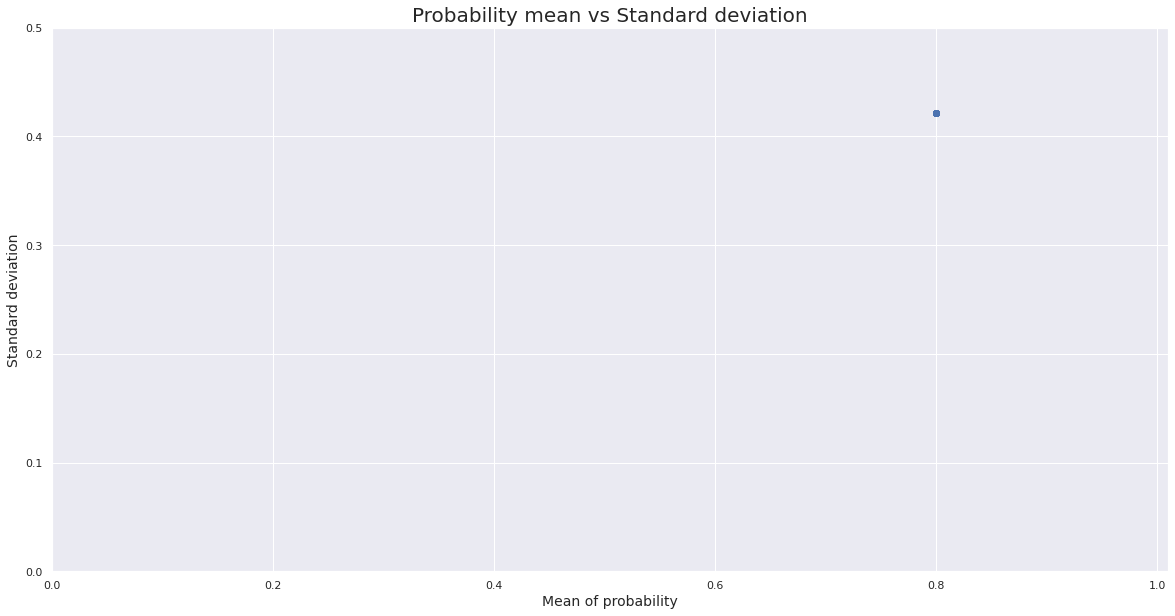

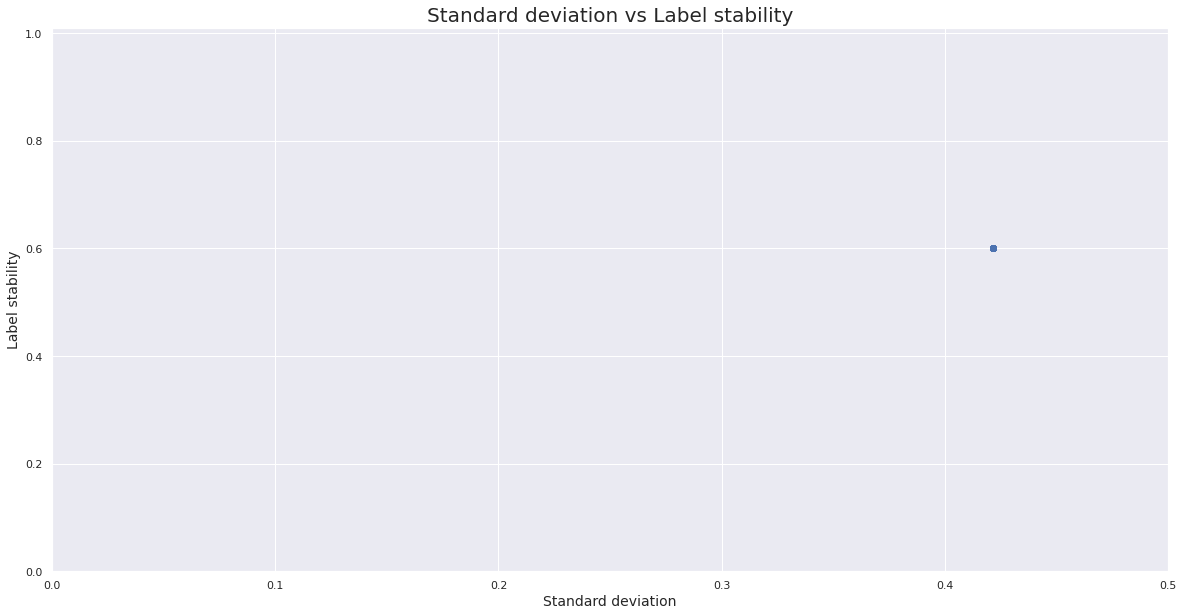

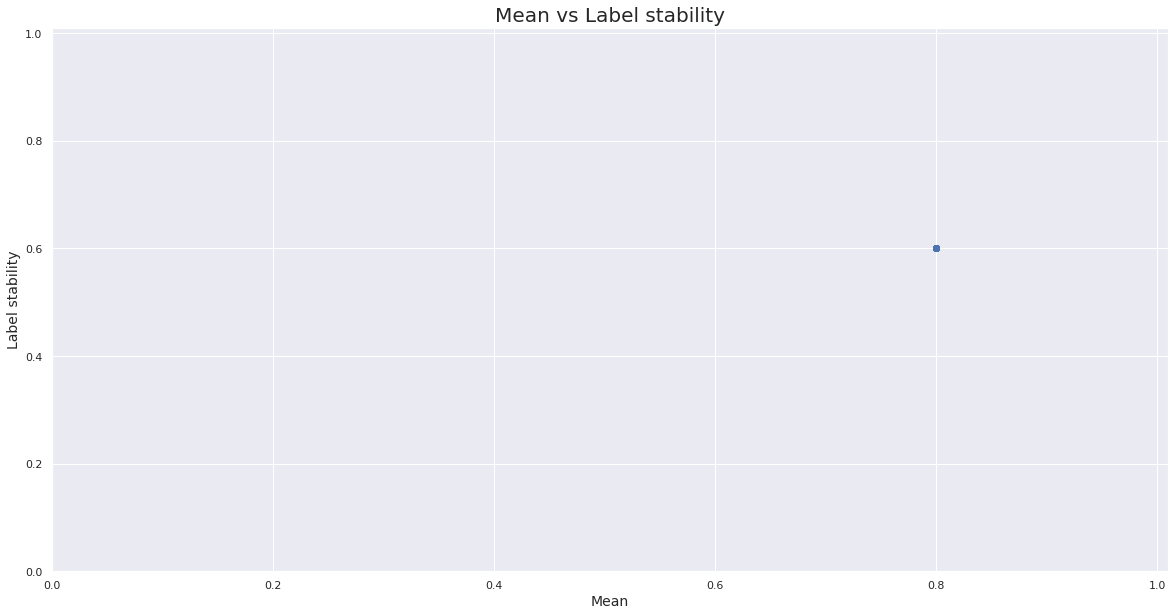

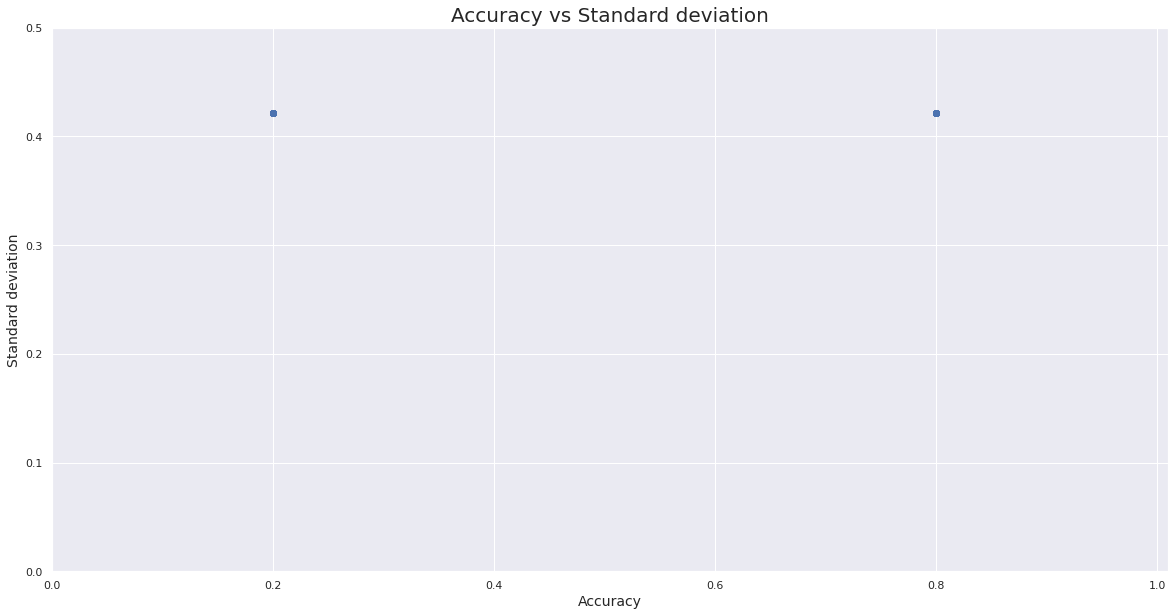

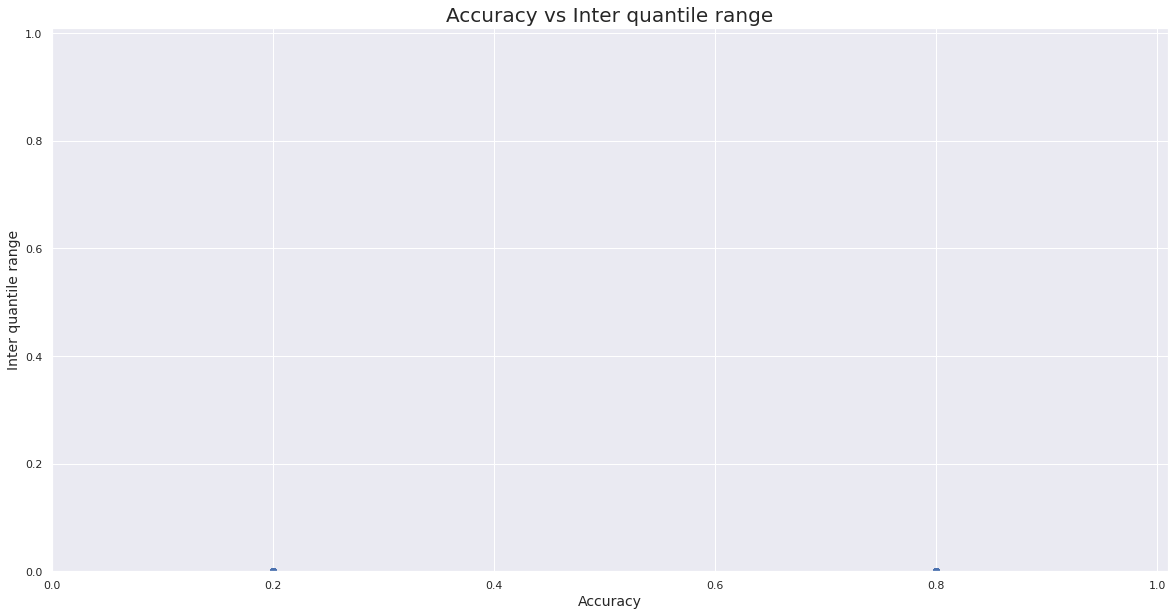

In [100]:
stability_analyzer.measure_stability_metrics(make_plots=True)